In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
# %matplotlib qt
import sys
sys.path.append('C:\code\qdc2')
import matplotlib.pyplot as plt 
import os 
import numpy as np 
from qdc.mmf.many_wl_fiber import ManyWavelengthFiber
from qdc.mmf.qdc_experiment import QDCMMFExperiment
from qdc.misc import tnow
DATA_DIR = os.path.join(os.path.abspath(os.path.curdir), 'data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
is_step_index = False
fiber_L = 0.1e6  if is_step_index else 0.5e6 # um 
N_wl = 81
N_classical = 1
N_SPDC = 1
wl0 = 0.810
Dwl = 0.020 if is_step_index else 0.080
NA_ref = 0.2   
# dzs = [80, 20, 0]
dzs = [0]

npoints = 2**7
s = ManyWavelengthFiber(wl0=wl0, Dwl=Dwl, N_wl=N_wl, fiber_L=fiber_L, rng_seed=5555, is_step_index=is_step_index, npoints=npoints, NA_ref=NA_ref)
s.gaussian_params = np.array([3, 6, 9, 0.4, 0.4]) 
s.gaussian_dparams = np.array([0, 3, 3, 0.15, 0.15])
# s.gaussian_dparams = np.array([0, 4, 4, 0.1, 0.1])

exp = QDCMMFExperiment(s)
res = exp.run_PCCs_different_dz(dzs=dzs, N_classical=N_classical, N_SPDC=N_SPDC)
# res.show(title='')
# res.show_incoherent_sum()

f_type = 'SI' if is_step_index else 'GRIN'
saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m.npz'
# res.saveto(saveto_path)

Getting 81 fibers...


81it [00:05, 14.81it/s]


Got fibers!
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


Getting SPDC with average on 1, dz=0 ...


Running SPDC measurements: 100%|██████████| 1/1 [00:11<00:00, 11.92s/it]


[ 3.          5.         11.          0.5325926   0.54043468]


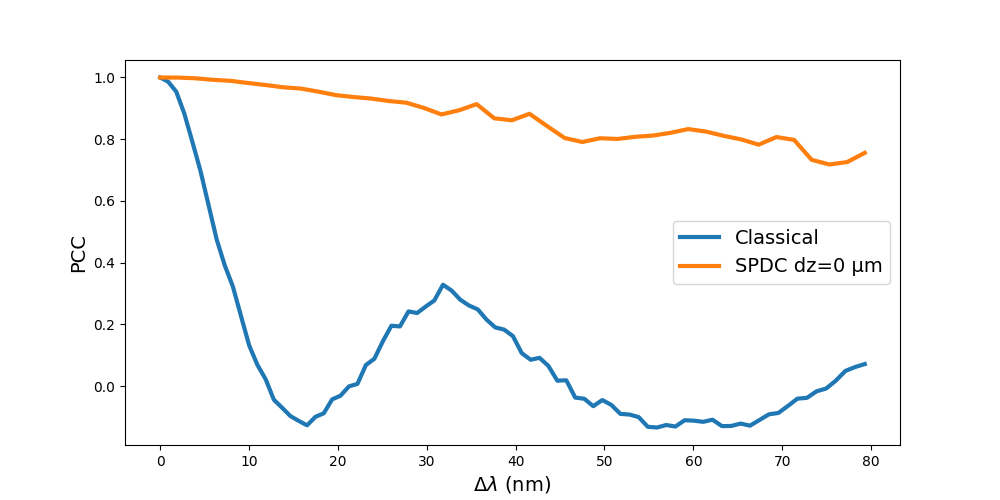

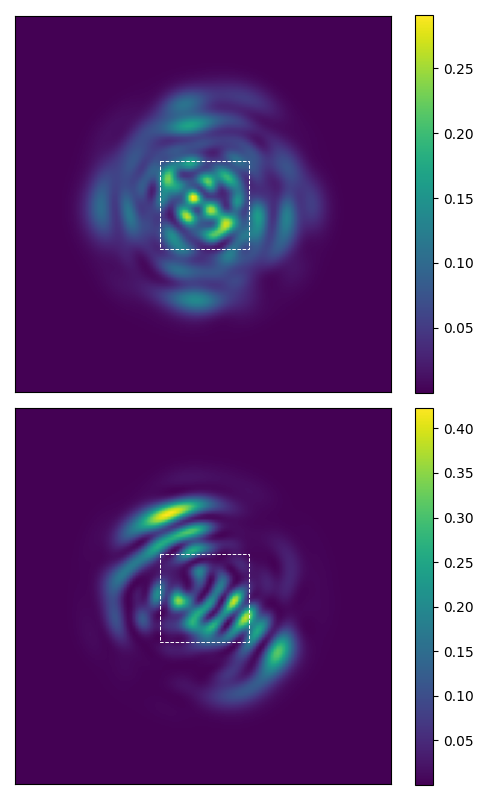

In [3]:
iter_no = None
dz = 0
print(res.metadata["g_params_list"][iter_no or 0])
res.show(title='', iter_no=iter_no)
res.show_incoherent_sum(iter_no=iter_no, dz=dz)

## View input and output fields + mode distribution for given gaussian params 

In [1]:
f = s.fibers[80]
f.set_input_gaussian(sigma=3, X0=5, Y0=10, X_linphase=0.4, Y_linphase=0.4, random_phase=0.0)
f.propagate(False)

fig, axes = plt.subplot_mosaic(
    [["left", "right"],
     ["bottom", "bottom"]],
    figsize=(9, 6)
)

from matplotlib import patches
# make circle centered in the middle of the plot
circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
axes["left"].add_patch(circle)
f.show_profile(f.profile_0,   ax=axes["left"],   title='input')
f.show_profile(f.profile_end, ax=axes["right"],  title='output')
axes["bottom"].plot(np.abs(f.modes_0)**2)
plt.tight_layout()


NameError: name 's' is not defined

In [14]:
f.show_mode(20)

In [11]:
for f in s.fibers:
    print(f.NA)
    print(f.Nmodes)

0.2000449936550287
210
0.20004385699198787
210
0.2000427202734481
210
0.20004158349409273
210
0.20004044664857829
210
0.20003930973152675
210
0.20003817273753227
210
0.2000370356611589
210
0.20003589849693837
210
0.2000347612393723
210
0.20003362388293003
210
0.20003248642205076
210
0.20003134885113916
210
0.20003021116457093
210
0.20002907335668946
208
0.20002793542180133
202
0.20002679735418644
200
0.2000256591480889
200
0.2000245207977184
198
0.20002338229725114
198
0.2000222436408332
196
0.20002110482257285
196
0.20001996583654705
194
0.20001882667679496
194
0.20001768733732558
194
0.20001654781210895
194
0.20001540809508167
192
0.20001426818014462
192
0.20001312806116084
192
0.20001198773196216
190
0.2000108471863414
190
0.2000097064180535
190
0.20000856542081769
190
0.20000742418831866
190
0.2000062827141988
190
0.2000051409920659
190
0.2000039990154921
190
0.20000285677800497
190
0.20000171427309973
190
0.2000005714942293
190
0.19999942843480975
190
0.19999828508821488
190
0.199